### Adam,  Sgdm with Tree Aggregate Implementation in PySpark
### Author: 
* Yi Rong (yirong@bu.edu)
* Xiaoyang Wang (gnayoaix@bu.edu)

### Date: 05/13/2021

In [36]:
from __future__ import print_function
import sys

from operator import add
# from string import lowercase
from re import sub, search
import numpy as np
from numpy.random.mtrand import dirichlet, multinomial
from string import punctuation
import random
import time
from scipy.stats import norm
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from random import sample

from pyspark.sql import functions as f, udf
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.mllib.stat import Statistics
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [37]:
# sc = SparkContext(appName="optimizer")

### Generate Data with make_blobs

In [38]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 400 # max iterations 
n=10000 # the number of total samples

In [39]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n, # the number of total samples
                  centers=n_components, # the number of clusters
                  n_features=n_feature, # the number of features
                  random_state=2) # 2

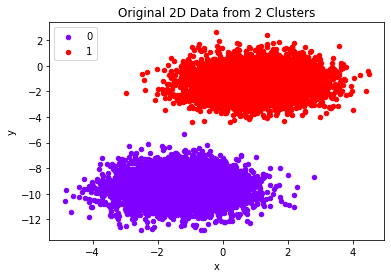

In [40]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

### Train a Logistic Regression Model

In [41]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.9, 0.1], seed=12345)
traindata.cache()

PythonRDD[4032] at RDD at PythonRDD.scala:53

In [42]:
train_size = traindata.count()

# TODO
add math for Adam and others 

# Also others 



In [44]:
def LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 256,
                       tolerance = 0.00001,
                       optimizer = 'None'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    train_size = traindata.count()

    parameter_size = len(traindata.take(1)[0][1]) + 1
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)

    momentum = np.zeros(parameter_size)
    history = np.array(parameter_size)

    for i in range(max_iteration):

#        bc_weights = sc.broadcast(parameter_vector[:-1])
#        bc1_weights = sc.broadcast(parameter_vector[-1])

        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (np.append(y[1], 1)) * (-y[0] + (np.exp(np.dot(y[1], bc_weights.value) + bc1_weights.value)\
                          /(1 + np.exp(np.dot(y[1], bc_weights.value) + bc1_weights.value)))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights.value) + bc1_weights.value)) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights.value)+ bc1_weights.value)),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))

        cost =  res[1] + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / res[2]) * res[0] + 2 * regularization * parameter_vector

        if optimizer == 'None':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='SGDM':
            beta = 0.9
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            parameter_vector = parameter_vector - learningRate * momentum
            
        if optimizer == 'Adam':
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 10e-8
            momentum = beta1 * momentum + (1 - beta1) * gradient_derivative
            history = beta2 * history + (1-beta2) * (gradient_derivative**2)
            momentum = momentum / (1 - beta1**(i + 1))
            history = history / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum / ((history)**0.5 + epsilon)


        if i%20 == 0 :
            print("Iteration No.", i, " Cost=", cost)

        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

### Model Evaluation

#### None Optimizer

In [45]:
parameter_vector_no, L_cost_no = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'None'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )

Iteration No. 0  Cost= 284.20632058110976
Iteration No. 20  Cost= 210.82469260449545
Iteration No. 40  Cost= 199.1623653176386
Iteration No. 60  Cost= 158.1548637058889
Iteration No. 80  Cost= 160.33819300428297
Iteration No. 100  Cost= 163.39609883468464
Iteration No. 120  Cost= 149.16396776549328
Iteration No. 140  Cost= 151.4636440401508
Iteration No. 160  Cost= 150.1422674295087
Iteration No. 180  Cost= 145.7177839922023
Iteration No. 200  Cost= 138.10467400922295
Iteration No. 220  Cost= 132.5846909018313
Iteration No. 240  Cost= 131.52942665948856
Iteration No. 260  Cost= 128.82133560350533
Iteration No. 280  Cost= 113.58465605233786
Iteration No. 300  Cost= 122.63025854985166
Iteration No. 320  Cost= 114.2360318797575
Iteration No. 340  Cost= 116.30706869017274
Iteration No. 360  Cost= 106.95254575887397
Iteration No. 380  Cost= 106.9030588999636


confusion matrix: (489, 0, 61, 461)
f1 score: 0.9379450661241098


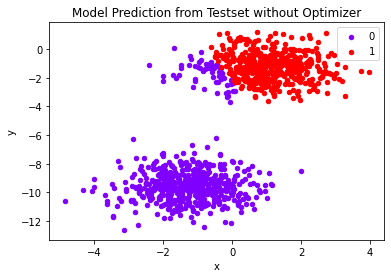

In [46]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_no), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset without Optimizer'.format(n_components))
pyplot.show()

#### Adam

In [47]:
parameter_vector_adam, L_cost_adam = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Adam'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )



Iteration No. 0  Cost= 284.20632058110976
Iteration No. 20  Cost= 281.2227389836434
Iteration No. 40  Cost= 273.8763704179741
Iteration No. 60  Cost= 243.82018299018932
Iteration No. 80  Cost= 254.973462804208
Iteration No. 100  Cost= 281.29487207086487
Iteration No. 120  Cost= 280.120237257935
Iteration No. 140  Cost= 276.86049519484516
Iteration No. 160  Cost= 279.0362670411174
Iteration No. 180  Cost= 290.3107025348632
Iteration No. 200  Cost= 281.0736147917977
Iteration No. 220  Cost= 265.65158362276645
Iteration No. 240  Cost= 280.8483125639647
Iteration No. 260  Cost= 278.6146618031642
Iteration No. 280  Cost= 259.0353349133694
Iteration No. 300  Cost= 270.50366230236006
Iteration No. 320  Cost= 259.31316474776935


<ipython-input-44-4d13ff9b9ab1>:60: RuntimeWarning: overflow encountered in true_divide
  history = history / (1 - beta2**(i + 1))


Iteration No. 340  Cost= 265.6734541654492
Iteration No. 360  Cost= 276.6139460707038
Iteration No. 380  Cost= 266.34251276417274


confusion matrix: (488, 1, 65, 457)
f1 score: 0.9326530612244898


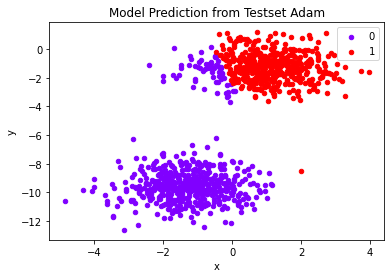

In [48]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_adam), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset Adam'.format(n_components))
pyplot.show()

#### SGDM

In [49]:
parameter_vector_sgdm, L_cost_sgdm = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'SGDM'  #optimizer: 'SGDM' / 'Adam' / 'None'
                      )

Iteration No. 0  Cost= 284.20632058110976
Iteration No. 20  Cost= 216.19464915307162
Iteration No. 40  Cost= 203.47084351938162
Iteration No. 60  Cost= 160.87622743678648
Iteration No. 80  Cost= 162.6290319683265
Iteration No. 100  Cost= 165.30301056376388
Iteration No. 120  Cost= 150.6784989003266
Iteration No. 140  Cost= 152.77562411846898
Iteration No. 160  Cost= 151.22795367962436
Iteration No. 180  Cost= 146.59916863192035
Iteration No. 200  Cost= 138.81525058811704
Iteration No. 220  Cost= 133.15844898725473
Iteration No. 240  Cost= 132.000461558648
Iteration No. 260  Cost= 129.22889615132297
Iteration No. 280  Cost= 113.8778347849357
Iteration No. 300  Cost= 122.84416628147417
Iteration No. 320  Cost= 114.4137429584161
Iteration No. 340  Cost= 116.47776065177295
Iteration No. 360  Cost= 107.04897625617544
Iteration No. 380  Cost= 106.97337471443917


confusion matrix: (489, 0, 62, 460)
f1 score: 0.9368635437881875


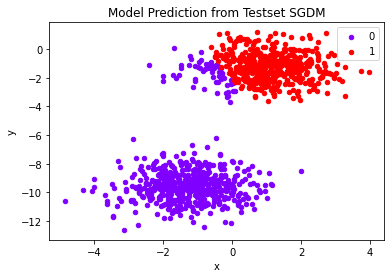

In [50]:
# check parameter_vector * x[1] is positive (label 1) or negative (label 0), x[0] is the actual label
rdd2 = testdata.map(lambda x: (np.dot(np.append(x[1], [1]), parameter_vector_sgdm), x[0])) \
    .map(lambda x: (np.where(x[0] >= 0, 1, 0), x[1])) \

# get confusion matrix result for each row: (TN, FP, FN, TP), 1 for true, 0 for false
rdd3 = rdd2.map(lambda x: (
np.where(x[0] == 0 and x[1] == 0, 1, 0), np.where(x[0] == 1 and x[1] == 0, 1, 0),  # confusion matrix
np.where(x[0] == 0 and x[1] == 1, 1, 0), np.where(x[0] == 1 and x[1] == 1, 1, 0)))

# calculate f1 score
cmat = rdd3.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
print("confusion matrix: " + str(cmat))
TN, FP, FN, TP = cmat[0], cmat[1], cmat[2], cmat[3]

if TP + FP != 0 and TP + FN != 0:
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    f1score = 2 * precision * recall / (precision + recall)
else:
    f1score = 0

print("f1 score: " + str(f1score))

# prediction on test set
y_pred = rdd2.map(lambda x: int(x[0])).collect()
X_test = np.array(testdata.map(lambda x: x[1]).collect())

# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_pred))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0,1,len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Model Prediction from Testset SGDM'.format(n_components))
pyplot.show()

### Optimizers Comparison

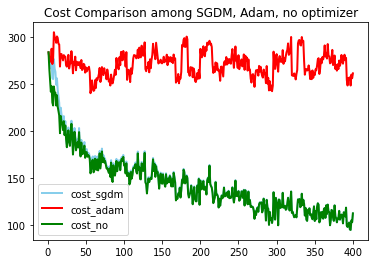

In [51]:
# Data
df = pd.DataFrame({'iteration': range(1, max_iter+1), 
                 'cost_sgdm': L_cost_sgdm, 
                 'cost_adam': L_cost_adam, 
                 'cost_no': L_cost_no })
 
# multiple line plots
pyplot.plot( 'iteration', 'cost_sgdm', data=df, marker='', color='skyblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_adam', data=df, marker='', color='red', linewidth=2)
pyplot.plot( 'iteration', 'cost_no', data=df, marker='', color='green', linewidth=2)
# show legend
pyplot.legend()
pyplot.title('Cost Comparison among SGDM, Adam, no optimizer')
# show graph
pyplot.show()

### F1 Score Comparison

* SGDM: 0.901
* Adam: 0.960
* No: 0.901